In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sopt
from pysimu import ode2numba, ssa

from ipywidgets import *


In [2]:
%matplotlib notebook

## System definition 

In [3]:
S_base = 100.0e6
U_base = 20e3
Z_base = U_base**2/S_base
r_km = 0.127 # ohm/km
x_km = 0.113 # ohm/km
lenght = 1.0
R = r_km*lenght/Z_base
X = x_km*lenght/Z_base
Z = R +1j*X
Y = 1.0/Z
G_s_inf, B_s_inf = Y.real, Y.imag

sys = { 't_end':20.0,'Dt':0.01,'solver':'forward-euler', 'decimation':10, 'name':'vsg_w',
   'models':[{'params':
                   {'H':6.0,
                    'X_s': 0.3,
                    'R_s': 0.1,
                    'K_p'  : 1.0,
                    'T_pi'  : 10.0,
                    'K_q':1.0,
                    'T_q':1.0,
                    'K_d':1.0,
                    'T_d':1.0,
                    'Omega_b' : 2*np.pi*60,
                    'B_s0':0.0,
                    'G_s_inf':G_s_inf,
                    'theta_inf': 0.0,  
                    'K_a':200.0,
                    'K_stab':10,
                    'B_s_inf':B_s_inf,
                    'G_s0':0.0,
                    'V_inf':1.0
                   },
              'f':[
                    'ddelta = Omega_b*(omega - 1)',
                    'domega = 1.0/(2*H)*(p_m - p_e - K_d*(omega - x_d))',
                    'dxi_q  = epsilon_q',
                    'dx_d = 1.0/T_d*(omega - x_d)',
                   ],
              'g':['ur@-ur + V_s*cos(theta_s)',  # polar to real
                   'ui@-ui + V_s*sin(theta_s)',  # polar to imag
                   'cosu@-cosu +ur/V_s',         # ideal PLL
                   'sinu@-sinu +ui/V_s',         # ideal PLL
                   'v_s_d@-v_s_d + ur*cosu + ui*sinu', # original park   
                   'v_s_q@-v_s_q - ur*sinu + ui*cosu', # original park  
                   'epsilon_q@-epsilon_q + Q_s_ref - Q_s',
                   'p_m@p_m - p_m_0',
                   'e    @ -e + K_q*(epsilon_q + xi_q/T_q) ', # 
                   'e_d@ e_d - e*cos(delta) ', # V 
                   'e_q@ e_q - e*sin(delta) ', # V  
                   'i_s_d@ -e_d + R_s*i_s_d - X_s*i_s_q + v_s_d', # VSC or SYM equation 
                   'i_s_q@ -e_q + R_s*i_s_q + X_s*i_s_d + v_s_q', # VSC or SYM equation 
                   'p_e@-p_e+ i_s_d*e_d + i_s_q*e_q', # active power equation 
                   'P_s@-P_s+ i_s_d*v_s_d + i_s_q*v_s_q', # active power equation 
                   'Q_s@-Q_s+ i_s_d*v_s_q - i_s_q*v_s_d', # reactive power equation 
                   'V_s@(G_s0 + G_s_inf)*V_s**2 - V_inf*(G_s_inf*cos(theta_s - theta_inf) + B_s_inf*sin(theta_s - theta_inf))*V_s - P_s',
                   'theta_s@(-B_s0 - B_s_inf)*V_s**2 + V_inf*(B_s_inf*cos(theta_s - theta_inf) - G_s_inf*sin(theta_s - theta_inf))*V_s - Q_s',
                      ],
              'u':{'p_m_0':0.8,'Q_s_ref':0.1},
              'y':['ur','ui','cosu','sinu','v_s_d','v_s_q','epsilon_q','p_m','e','e_d','e_q','i_s_d','i_s_q','p_e','P_s','Q_s','V_s','theta_s'],
              'y_ini':['ur','ui','cosu','sinu','v_s_d','v_s_q','epsilon_q','p_m','e','e_d','e_q','i_s_d','i_s_q','p_e','P_s','Q_s','V_s','theta_s'],
              'h':[
                   'omega'
                   ]}
              ],
    'perturbations':[{'type':'step','time':1.0,'var':'p_m_0','final':1.01} ]
    }

x,f = ode2numba.system(sys)  ;


ur
ui
cosu
sinu
v_s_d
v_s_q
epsilon_q
p_m
e    
e_d
e_q
i_s_d
i_s_q
p_e
P_s
Q_s
V_s
theta_s
Matrix([[ur], [ui], [cosu], [sinu], [v_s_d], [v_s_q], [epsilon_q], [p_m], [e], [e_d], [e_q], [i_s_d], [i_s_q], [p_e], [P_s], [Q_s], [V_s], [theta_s]])
N_y 18
-ur + V_s*sym.cos(theta_s), -ui + V_s*sym.sin(theta_s), -cosu +ur/V_s, -sinu +ui/V_s, -v_s_d + ur*cosu + ui*sinu, -v_s_q - ur*sinu + ui*cosu, -epsilon_q + Q_s_ref - Q_s, p_m - p_m_0,  -e + K_q*(epsilon_q + xi_q/T_q) ,  e_d - e*sym.cos(delta) ,  e_q - e*sym.sin(delta) ,  -e_d + R_s*i_s_d - X_s*i_s_q + v_s_d,  -e_q + R_s*i_s_q + X_s*i_s_d + v_s_q, -p_e+ i_s_d*e_d + i_s_q*e_q, -P_s+ i_s_d*v_s_d + i_s_q*v_s_q, -Q_s+ i_s_d*v_s_q - i_s_q*v_s_d, (G_s0 + G_s_inf)*V_s**2 - V_inf*(G_s_inf*sym.cos(theta_s - theta_inf) + B_s_inf*sym.sin(theta_s - theta_inf))*V_s - P_s, (-B_s0 - B_s_inf)*V_s**2 + V_inf*(B_s_inf*sym.cos(theta_s - theta_inf) - G_s_inf*sym.sin(theta_s - theta_inf))*V_s - Q_s, 


In [4]:
import vsg_w

In [5]:
syst = vsg_w.vsg_w_class()
x0 = np.ones(syst.N_x+syst.N_y)
x0[0] = 0
s = sopt.fsolve(syst.run_problem,x0 )
print(s)

[ 1.82811312e-01  1.00000000e+00  1.14680004e+00  1.00000000e+00
  1.02554180e+00  1.79032498e-02  9.99847655e-01  1.74546979e-02
  1.02569806e+00 -5.55212004e-11 -9.15673562e-23  8.00000000e-01
  1.14680004e+00  1.12769033e+00  2.08482231e-01  7.27438963e-01
 -9.74945777e-02  8.00000000e-01  7.46132736e-01  1.00000000e-01
  1.02569806e+00  1.74555843e-02]


In [6]:
s[7]

0.01745469785228096

<IPython.core.display.Javascript object>


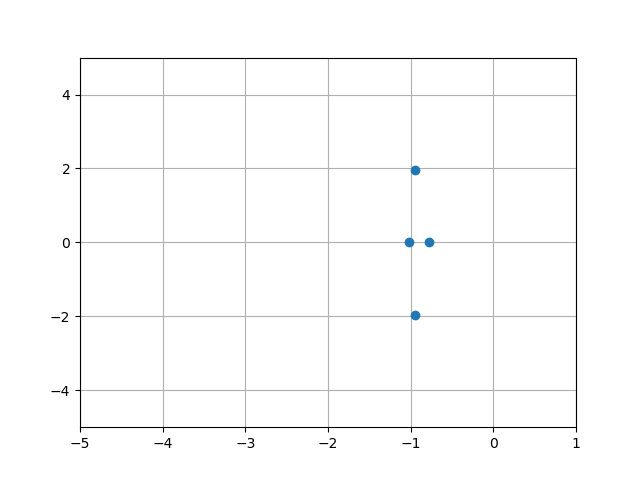

delta = 12.43, V_s = 1.03, zeta = 100.00 %, freq = 0.00


In [9]:
fig,axes = plt.subplots(nrows=1)
points = axes.plot([],[],'o')
axes.set_xlim(-5,1)
axes.set_ylim(-5,5)
axes.grid(True)
def Jac(x):
  
    J=np.vstack((np.hstack((syst.struct[0].Fx,syst.struct[0].Fy)),np.hstack((syst.struct[0].Gx,syst.struct[0].Gy))))
    return J

def update(p_m_0 = 0.9, Q_s_ref=0.0, K_d=0.0):
    syst.struct[0].p_m_0 = p_m_0
    syst.struct[0].Q_s_ref = Q_s_ref
    syst.struct[0].K_d = K_d
   # if T_pi <0.001: T_pi = 0.001
   # syst.struct[0].T_pi = T_pi
    x0 = np.vstack([syst.struct[0].x, syst.struct[0].y])
    x0 = np.ones(syst.N_x+syst.N_y)
    #x0[0,0] = 0.0

    frime = np.vstack((syst.struct[0].f,syst.struct[0].g))
    s = sopt.fsolve(syst.run_problem,x0 )
    syst.struct[0].x[:,0] = s[0:syst.N_x]
    syst.struct[0].y[:,0] = s[syst.N_x:(syst.N_x+syst.N_y)]
    #print(np.linalg.det(syst.struct[0].Gy))
    e,v = np.linalg.eig(ssa.eval_A(syst))
    points[0].set_xdata(e.real)
    points[0].set_ydata(e.imag/np.pi/2)
    delta = np.rad2deg(syst.struct[0].x[0,0])
    V_s = syst.struct[0].y[-2,0]
    
    print(f'delta = {delta:.2f}, V_s = {V_s:.2f}, zeta = {-100*e[0].real/abs(e[0]):.2f} %, freq = {e[0].imag/2/np.pi:.2f}')
    fig.canvas.draw()
update()

In [10]:
interact(update, p_m_0  =widgets.FloatSlider(min=0.0,max=1.2,step=0.1,value=0.8, continuous_update=True),
                 Q_s_ref  =widgets.FloatSlider(min=-0.5,max=0.5,step=0.1,value=0.8, continuous_update=False),
                 K_d  =widgets.FloatSlider(min=0.0,max=50.0,step=0.1,value=0.8, continuous_update=False), 
        );

interactive(children=(FloatSlider(value=0.8, description='p_m_0', max=1.2), FloatSlider(value=0.5, continuous_…